In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy.linalg as LA

In [2]:
import Function as f

Setting the Hyper-Parameter:

In [3]:
max_iteration = 10000
weight_decay = 1e-5
NUM_EMPLOYEES = 1200
NUM_TRAIN = 1000
NUM_VAL = 200
Epsilons = [10,10]
NUM_FEATURES = 5
BANDWIDTH = 0.5

In [4]:
X, Y, survival_times = f.Generating_Synthetic_Set(NUM_EMPLOYEES, NUM_FEATURES, Epsilons, bias = False)

Discard the top 5% longevity training samples

In [5]:
five_percent = int(len(survival_times) * 0.05)
five_percent_indices = np.argsort(survival_times)[(-1) * five_percent:]
threshold_age = survival_times[five_percent_indices[0]]
for i in five_percent_indices:
    while(True):
        Epsilon_1, Epsilon_2 = Epsilons
        _lambda = Epsilon_1 * np.sum(X[i, :] ** 2) + Epsilon_2 * np.sum(X[i, :])
        age = np.ceil(np.random.exponential(_lambda, size=1))
        if age <= threshold_age:
            survival_times[i] = age
            break
NUM_TASKS = int(np.max(survival_times))
Y = np.ones((NUM_EMPLOYEES, NUM_TASKS))
# the lifetime matrix of all employees, if one employee leave at the time interval k, then from Y[i,k](inlcude)  all entries are -1
for i in range(NUM_EMPLOYEES):
    Y[i, int(survival_times[i]):] = -1

In [6]:
X_train = X[:NUM_TRAIN]
X_val = X[NUM_TRAIN:]
Y_train = Y[:NUM_TRAIN]
Y_val = Y[NUM_TRAIN:]

In [7]:
# Kernel_Matrix = f.Generating_Kernel(X, "Gaussian_Kernel", BW = BANDWIDTH)
Kernel_Matrix = f.Generating_Kernel(X, "Quick_Gaussian_Kernel", BW = BANDWIDTH)
Kernel_Matrix_Train = Kernel_Matrix[:NUM_TRAIN,:NUM_TRAIN]
Kernel_Matrix_Val = Kernel_Matrix[NUM_TRAIN:,:NUM_TRAIN]

There are  1422944 pairs of samples of similarity between 0.0 and 0.1 which have an average age_gap  44.57235000112443 and the median is: 31.0
There are  9066 pairs of samples of similarity between 0.1 and 0.2 which have an average age_gap  29.29869843370836 and the median is: 17.0
There are  3374 pairs of samples of similarity between 0.2 and 0.3 which have an average age_gap  28.04149377593361 and the median is: 16.0
There are  1620 pairs of samples of similarity between 0.3 and 0.4 which have an average age_gap  28.534567901234567 and the median is: 16.0
There are  876 pairs of samples of similarity between 0.4 and 0.5 which have an average age_gap  27.40639269406393 and the median is: 17.0
There are  486 pairs of samples of similarity between 0.5 and 0.6 which have an average age_gap  28.93415637860082 and the median is: 14.0
There are  254 pairs of samples of similarity between 0.6 and 0.7 which have an average age_gap  19.37007874015748 and the median is: 11.0
There are  132 pair

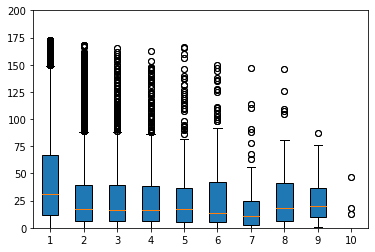

In [8]:
f.Validate_Synthetic_DataSet(Kernel_Matrix, survival_times)

Have a quick look at the distribution of ages:

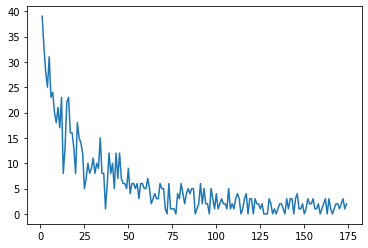

In [9]:
NUM_TASKS = Y.shape[1]
x_axis = np.arange(NUM_TASKS)+1
y_train_gt_axis = np.zeros(NUM_TASKS)
for i in range(NUM_TASKS):
    y_train_gt_axis[i] = np.sum(survival_times[:NUM_TRAIN] == x_axis[i])
plt.plot(x_axis, y_train_gt_axis)

In [10]:
alpha = np.zeros_like(Y_train) 
predict_age = np.zeros(NUM_EMPLOYEES) 
val_loss_list = []
index = 0
for t in range(1, max_iteration+1):

    alpha = f.Kernel_Pegasos(1, Kernel_Matrix_Train, alpha, Y_train, t, weight_decay)
    
    if t%500 == 0: 
        print("the iteration is:", t)
        hatY_train = Kernel_Matrix_Train.dot(alpha*Y_train) / ( t * weight_decay )
        
        hatY_val =  Kernel_Matrix_Val.dot(alpha*Y_train) / ( t * weight_decay )
        
        predict_age_tr = f.Ages(hatY_train)
        predict_age_val = f.Ages(hatY_val)
        predict_age = predict_age_tr + predict_age_val
            
        acc_train = np.sum(Y_train * hatY_train > 0) / (NUM_TRAIN * NUM_TASKS)
        acc_val = np.sum(Y_val * hatY_val > 0) / (NUM_VAL * NUM_TASKS)
        print("the train accuracy is:", acc_train)
        print("the val accuracy is:", acc_val)
        
        # C_index_tr = f.Calculate_C_index(survival_times[:NUM_TRAIN], predict_age_tr)
        C_index_val = f.Calculate_C_index(survival_times[NUM_TRAIN:], predict_age_val)
         
        # print("the c-index for training is:", C_index_tr)xx
        print("the c-index for val is:", C_index_val)
  
print(np.sum(predict_age[NUM_TRAIN:] == survival_times[NUM_TRAIN:])/(NUM_VAL))

the iteration is: 500
the train accuracy is: 0.841919540229885
the val accuracy is: 0.803764367816092
11974 19638.0
the c-index for val is: 0.6097362256848966
the iteration is: 1000
the train accuracy is: 0.8770517241379311
the val accuracy is: 0.8126436781609195
11414 19638.0
the c-index for val is: 0.5812200835115592
the iteration is: 1500
the train accuracy is: 0.8988275862068965
the val accuracy is: 0.8239655172413793
11296 19638.0
the c-index for val is: 0.5752113249821774
the iteration is: 2000
the train accuracy is: 0.9207643678160919
the val accuracy is: 0.8306609195402299
11464 19638.0
the c-index for val is: 0.5837661676341787
the iteration is: 2500
the train accuracy is: 0.9319770114942528
the val accuracy is: 0.8401436781609195
11659 19638.0
the c-index for val is: 0.5936958957123943
the iteration is: 3000
the train accuracy is: 0.9378505747126437
the val accuracy is: 0.8425287356321839
11786 19638.0
the c-index for val is: 0.6001629493838476
the iteration is: 3500
the trai

In [11]:
alpha = np.zeros_like(Y_train)
predict_age = np.zeros(NUM_EMPLOYEES)
val_loss_list = []
index = 0
for t in range(1, max_iteration + 1):

    alpha = f.Split_Kernel_Pegasos(1, Kernel_Matrix_Train, alpha, Y_train, t, weight_decay)

    if t % 100 == 0:
        print("the iteration is:", t)
        hatY_train = Kernel_Matrix_Train.dot(alpha * Y_train) / (t * weight_decay)
        hatY_val = Kernel_Matrix_Val.dot(alpha * Y_train) / (t * weight_decay)

        predict_age_tr = f.Ages(hatY_train)
        predict_age_val = f.Ages(hatY_val)
        predict_age = predict_age_tr + predict_age_val

        acc_train = np.sum(Y_train * hatY_train > 0) / (NUM_TRAIN * NUM_TASKS)
        acc_val = np.sum(Y_val * hatY_val > 0) / (NUM_VAL * NUM_TASKS)
        print("the train accuracy is:", acc_train)
        print("the val accuracy is:", acc_val)

        # C_index_tr = f.Calculate_C_index(survival_times[:NUM_TRAIN], predict_age_tr)
        C_index_val = f.Calculate_C_index(survival_times[NUM_TRAIN:], predict_age_val)

        # print("the c-index for training is:", C_index_tr)
        print("the c-index for val is:", C_index_val)

print(np.sum(predict_age[NUM_TRAIN:] == survival_times[NUM_TRAIN:]) / (NUM_VAL))

the iteration is: 100
the train accuracy is: 0.8145172413793104
the val accuracy is: 0.8354597701149425
3013 19638.0
the c-index for val is: 0.15342702922904572
the iteration is: 200
the train accuracy is: 0.8175172413793104
the val accuracy is: 0.839683908045977
2704 19638.0
the c-index for val is: 0.13769222935125777
the iteration is: 300
the train accuracy is: 0.8245402298850575
the val accuracy is: 0.8463793103448276
6191 19638.0
the c-index for val is: 0.3152561360627355
the iteration is: 400
the train accuracy is: 0.8288390804597701
the val accuracy is: 0.8476149425287356
10023 19638.0
the c-index for val is: 0.5103880232202872
the iteration is: 500
the train accuracy is: 0.829551724137931
the val accuracy is: 0.8472413793103448
10786 19638.0
the c-index for val is: 0.5492412669314595
the iteration is: 600
the train accuracy is: 0.8334425287356322
the val accuracy is: 0.8558045977011495
12205 19638.0
the c-index for val is: 0.6214991343313984
the iteration is: 700
the train accur

the iteration is: 5200
the train accuracy is: 0.8771896551724138
the val accuracy is: 0.8498850574712644
12242 19638.0
the c-index for val is: 0.6233832365821367
the iteration is: 5300
the train accuracy is: 0.8775919540229885
the val accuracy is: 0.850632183908046
12236 19638.0
the c-index for val is: 0.6230777064874223
the iteration is: 5400
the train accuracy is: 0.8778965517241379
the val accuracy is: 0.8504885057471264
12220 19638.0
the c-index for val is: 0.6222629595681841
the iteration is: 5500
the train accuracy is: 0.8784425287356322
the val accuracy is: 0.850632183908046
12221 19638.0
the c-index for val is: 0.6223138812506365
the iteration is: 5600
the train accuracy is: 0.8791551724137932
the val accuracy is: 0.8498275862068966
12152 19638.0
the c-index for val is: 0.6188002851614217
the iteration is: 5700
the train accuracy is: 0.8797413793103448
the val accuracy is: 0.8498850574712644
12144 19638.0
the c-index for val is: 0.6183929117018027
the iteration is: 5800
the tra

In [12]:
print(np.sum(survival_times[NUM_TRAIN:] - predict_age[NUM_TRAIN:] < 0))
print(np.sum(survival_times[NUM_TRAIN:] - predict_age[NUM_TRAIN:] > 0))
print(print(np.sum(survival_times[NUM_TRAIN:] - predict_age[NUM_TRAIN:] == 0)))
print(survival_times[NUM_TRAIN:])
print(predict_age[NUM_TRAIN:])
print(np.mean(abs(survival_times[NUM_TRAIN:] - predict_age[NUM_TRAIN:])))

73
120
7
None
[ 13. 168.   7.  15.  57.   2.  50. 160.  19.   1.   4.  24.  23.   3.
  23.   9.  81.   8.  27.   5.  23.  20. 118.  42.  12.  69.   3.   2.
  17.   3.  21.  24.   4.   2.  65.   1.  35.  70.  36.  30.   4.  94.
  10. 157.  39.   9.  26.  13.  54.  44.  17.  26.  91.   6.  86.  15.
   2.   1.  26.  14. 109.  25.   6.   5. 148.  54.  38.  87.   9. 111.
  68.  33.  10.  79.  69.  52.  88.   6. 102. 143.  47.  50.  34.  89.
  86.  19.  68.  11.  36.  25.   6.  34.  43.   2.  26.  47.  56.  15.
   1.  16.  20.   2.  46.   2.  15. 101.  29.  73.  55.  44.   6.  12.
  11.   3.  49.  18.  32.  33.   3.  42.  34.  16.  10.   2.  19. 162.
  69.  47.  14.  35.  78.  20.  13.   2.   5.   7.  69.  18.  51.  71.
  41.  42.  22.  72.  84.   8.  92.  19.   3.  13.  22.  12.  90.  29.
  56.  43. 113.  39. 114.  78.  14.  73.  11.  10.  25.  20.  12.   1.
   8.   7. 109.   6.   3.  66.   7.   3.   1.  18.  39.   8.  14.  52.
 124.  26.  10.  23.   4.   9.  17.   7.  20.  18.  13.  26.  7

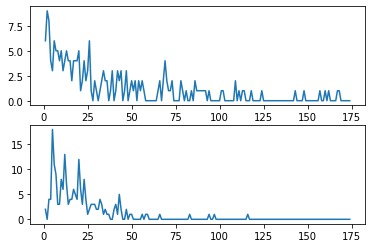

In [13]:
x_axis = np.arange(NUM_TASKS)+1 # the x axis
y_train_gt_axis = np.zeros(NUM_TASKS) # the ground truth train axis
y_val_gt_axis = np.zeros(NUM_TASKS) # the groud truth validation axis 
y_train_predict_axis = np.zeros(NUM_TASKS) # the predict train axis 
y_val_predict_axis = np.zeros(NUM_TASKS) # the predict validation axis 

for i in range(NUM_TASKS):
    y_train_gt_axis[i] = np.sum(survival_times[:NUM_TRAIN] == x_axis[i])
    y_val_gt_axis[i] = np.sum(survival_times[NUM_TRAIN:] == x_axis[i])
    y_train_predict_axis[i] = np.sum(predict_age[:NUM_TRAIN] == x_axis[i])
    y_val_predict_axis[i] = np.sum(predict_age[NUM_TRAIN:] == x_axis[i])
# plt.plot(x_axis, y_train_gt_axis, x_axis, y_train_predict_axis) # the training set: ground truth vs predict situation
# plt.plot(x_axis, y_val_gt_axis, x_axis, y_val_predict_axis) # the valiadtion set: ground truth vs predictsituation
plt.subplot(211)
plt.plot(x_axis, y_val_gt_axis)
plt.subplot(212)
plt.plot(x_axis, y_val_predict_axis)
# plt.plot(x_axis,y_train_predict_axis,y_val_predict_axis)

In [14]:
Yhat_tr = Kernel_Matrix_Train.dot(alpha * Y_train)
good = 0
mzz =[]
for i in range(NUM_TRAIN):
    num_violates_ranking_constraints = np.sum(Yhat_tr[i, int(survival_times[i]): ] > 0)
    predict_gap = survival_times[i] - predict_age[i]
    # print(num_violates_ranking_constraints)
    if num_violates_ranking_constraints == 0:
        good += 1
    else:
        mzz.append(np.sign(num_violates_ranking_constraints * predict_gap))
        # mzz.append((num_violates_ranking_constraints, predict_gap))
print(good)
print(NUM_TRAIN)

506
1000


In [15]:
print(np.sum(np.array(mzz) < 0))
print(np.array(mzz).size)

308
494


In [16]:
for i in range(len(IDs)):
    idx_last_1 = np.where(haty_IDs[i] == 1)[0][-1] # find the last 1
    idx_minus1_list = np.where(haty_IDs[i][:idx_last_1] == -1)[0] # find all -1 before the last 1
    idx_last_minus1 = idx_minus1_list[-1]
    idx_1_list = np.where(haty_IDs[i][idx_last_minus1:idx_last_1] == 1)[0]

NameError: name 'IDs' is not defined

In [ ]:
c = np.array([1,2,3,4])
print(np.tile(c,(4,1)).T)